In [1]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: Rcpp

ℹ Loading Socrates

Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplica

In [2]:
rep_1 <- paste0(data_path,"Sb.Leaf_rep1_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"Sb.Leaf_rep2_QC_soc_obj.rds")
prefix <- "Sb_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [ ]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

In [ ]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [2]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t=0.001, # maximum feature frequency across cells
                     verbose=T)


# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'colSums': object 'soc.obj' not found


In [6]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="NMF", 
                      n.pcs=20, 
                      num.var=30000,
                      svd_slotName="NMF")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="NMF")

 - non-linear dimensionality reduction with UMAP ...

10:39:04 UMAP embedding parameters a = 1.896 b = 0.8006

10:39:04 Read 17428 rows and found 20 numeric columns

10:39:04 Using Annoy for neighbor search, n_neighbors = 25

10:39:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:39:06 Writing NN index file to temp file /tmp/RtmpY7ipXI/file30d5c7de32ef3

10:39:06 Searching Annoy index using 16 threads, search_k = 2500

10:39:07 Annoy recall = 100%

10:39:09 Commencing smooth kNN distance calibration using 16 threads

10:39:12 Initializing from normalized Laplacian + noise

10:39:12 Commencing optimization for 200 epochs, with 639026 positive edges

10:39:33 Optimization finished



In [7]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "NMF", svd_slotName="NMF")

 - Creating synthetic doublets ...

Warning message in mclapply(seq_len(nTrials), function(y) {:
"scheduled cores 1, 3 did not deliver results, all values of the jobs will be affected"
 - Created 67000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [8]:
str(tfidf.obj.dob$counts)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:55185969] 8 9 13 17 18 19 20 21 22 24 ...
  ..@ p       : int [1:17429] 0 48026 68236 107090 144865 181056 203244 238236 270271 301472 ...
  ..@ Dim     : int [1:2] 106707 17428
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:106707] "Chr01_10000001_10000500" "Chr01_10004501_10005000" "Chr01_10006501_10007000" "Chr01_10007501_10008000" ...
  .. ..$ : chr [1:17428] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:GCCAATTAGCTTAGCGAGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1" ...
  ..@ x       : num [1:55185969] 1 1 1 1 1 1 1 1 1 1 ...
  ..@ factors : list()


In [9]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [10]:
str((tfidf.obj.dob.filt$meta))

'data.frame':	17428 obs. of  12 variables:
 $ cellID      : chr  "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:GCCAATTAGCTTAGCGAGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1" ...
 $ total       : num  193716 159908 137820 133866 119905 ...
 $ tss         : num  115473 50092 80881 76902 69087 ...
 $ acrs        : num  154235 29336 99700 96929 90787 ...
 $ ptmt        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ nSites      : num  57999 80678 48802 47311 44916 ...
 $ log10nSites : num  4.76 4.91 4.69 4.67 4.65 ...
 $ sampleID    : chr  "rep1" "rep1" "rep1" "rep1" ...
 $ umap1       : num  3.08 2.63 4.5 5.16 -3.24 ...
 $ umap2       : num  -4.97 2.52 -2.39 -1.9 -8.25 ...
 $ doubletscore: num  0.224 0.418 0.537 0.224 0.552 ...
 $ d.type      : chr  "singlet" "singlet" "singlet" "singlet" ...


In [20]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
prcnt_to_remove

[1] 2.666365

In [21]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'sort': object 'tfidf.obj.dob.filt' not found


── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ readr::col_factor() masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ purrr::discard()    masks Socrates::discard(), scales::discard()
✖ tidyr::expand()     masks Socrates::expand(), S4Vectors::expand(), Matrix::expand()
✖ tidyr::fill()       masks VGAM::fill()
✖ dpl

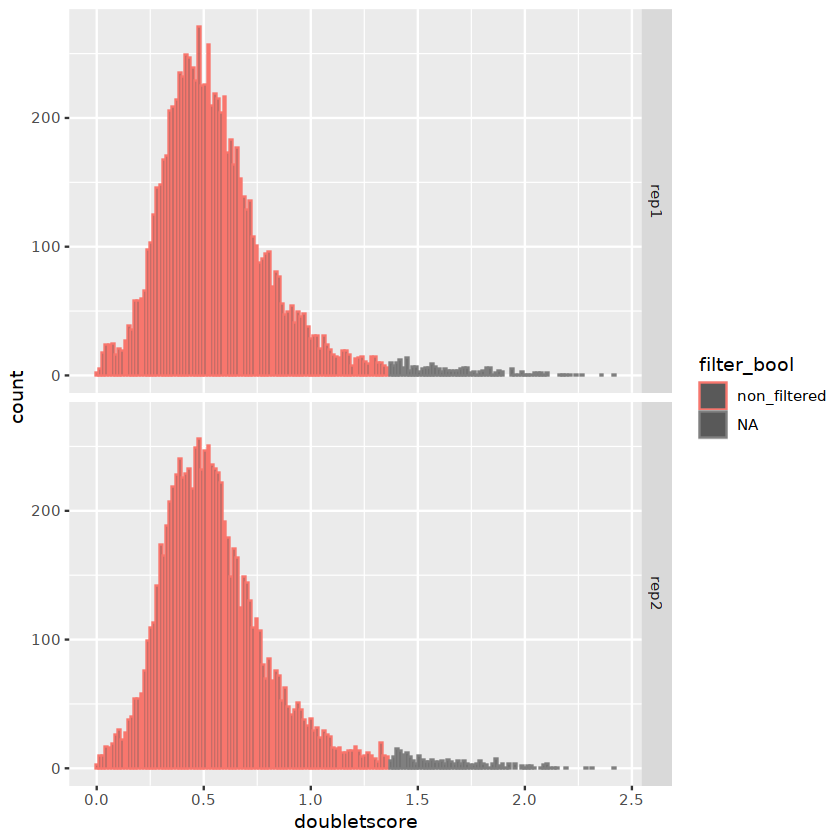

In [14]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore < remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

In [ ]:
typeof(tfidf.obj.dob.filt$meta)

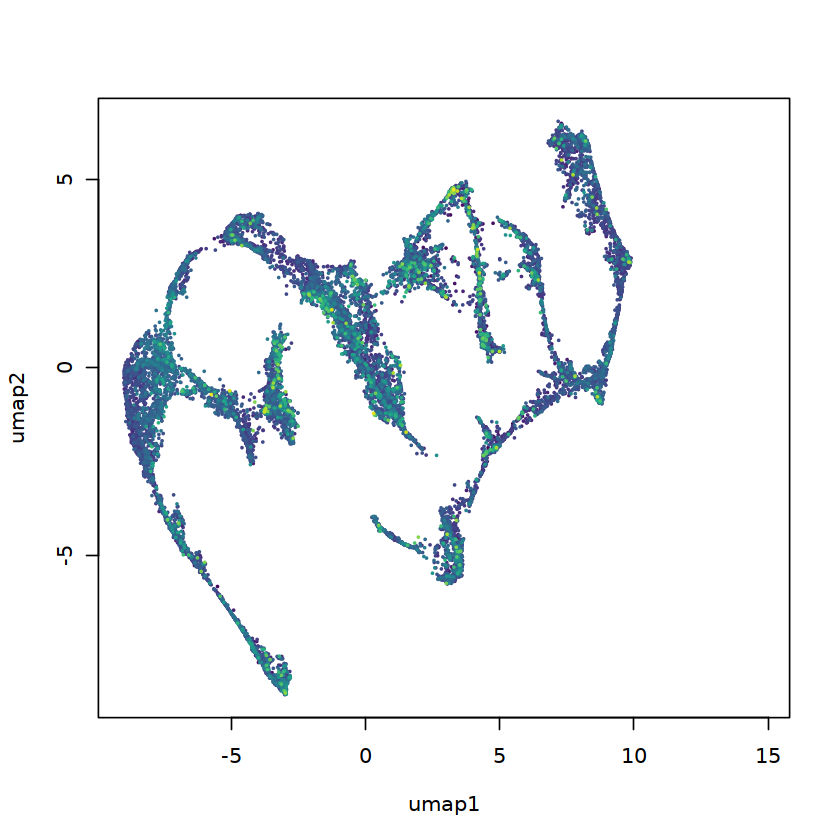

In [15]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "doubletscore")

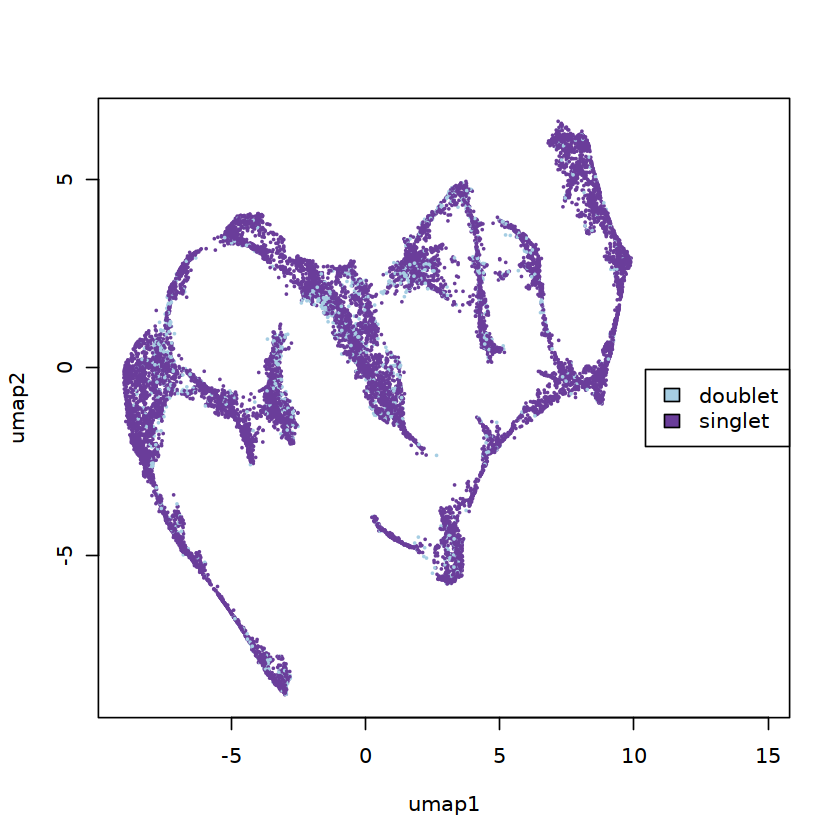

In [16]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "d.type")

In [12]:
library(tidyverse)
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < calculated_value) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

── Attaching packages ───────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ──────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ readr::col_factor() masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ purrr::discard()    masks Socrates::discard(), scales::discard()
✖ tidyr::expand()     masks Socrates::expand(), S4Vectors::expand(), Matrix::expand()
✖ tidyr::fill()       masks VGAM::fill()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Socrates::pac

In [38]:
tfidf.obj.dob.filt.removed.graph <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
head(tfidf.obj.dob.filt.removed.graph)

cellID,total,tss,acrs,ptmt,nSites,log10nSites,sampleID,umap1,umap2,doubletscore,d.type,filter_bool
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1,193716,115473,154235,0,57999,4.763421,rep1,3.078911,-4.9729073,0.2238806,singlet,non_filtered
BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1,159908,50092,29336,0,80678,4.906755,rep1,2.628450,2.5201121,0.4179104,singlet,non_filtered
BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1,137820,80881,99700,0,48802,4.688438,rep1,4.499065,-2.3879704,0.5373134,singlet,non_filtered
BC:Z:GCCAATTAGCTTAGCGAGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1,133866,76902,96929,0,47311,4.674962,rep1,5.158868,-1.9025369,0.2238806,singlet,non_filtered
BC:Z:ACAGTGCCGTCCCTAAGGTAGAGTCGG-Sorghum_leaf.sciATAC_rep1,119905,69087,90787,0,44916,4.652401,rep1,-3.244552,-8.2455465,0.5522388,singlet,non_filtered
BC:Z:ACAGTGCCGTCCCTAAGGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1,116704,44610,44540,0,56389,4.751194,rep1,-3.735852,-0.5444418,0.2686567,singlet,non_filtered


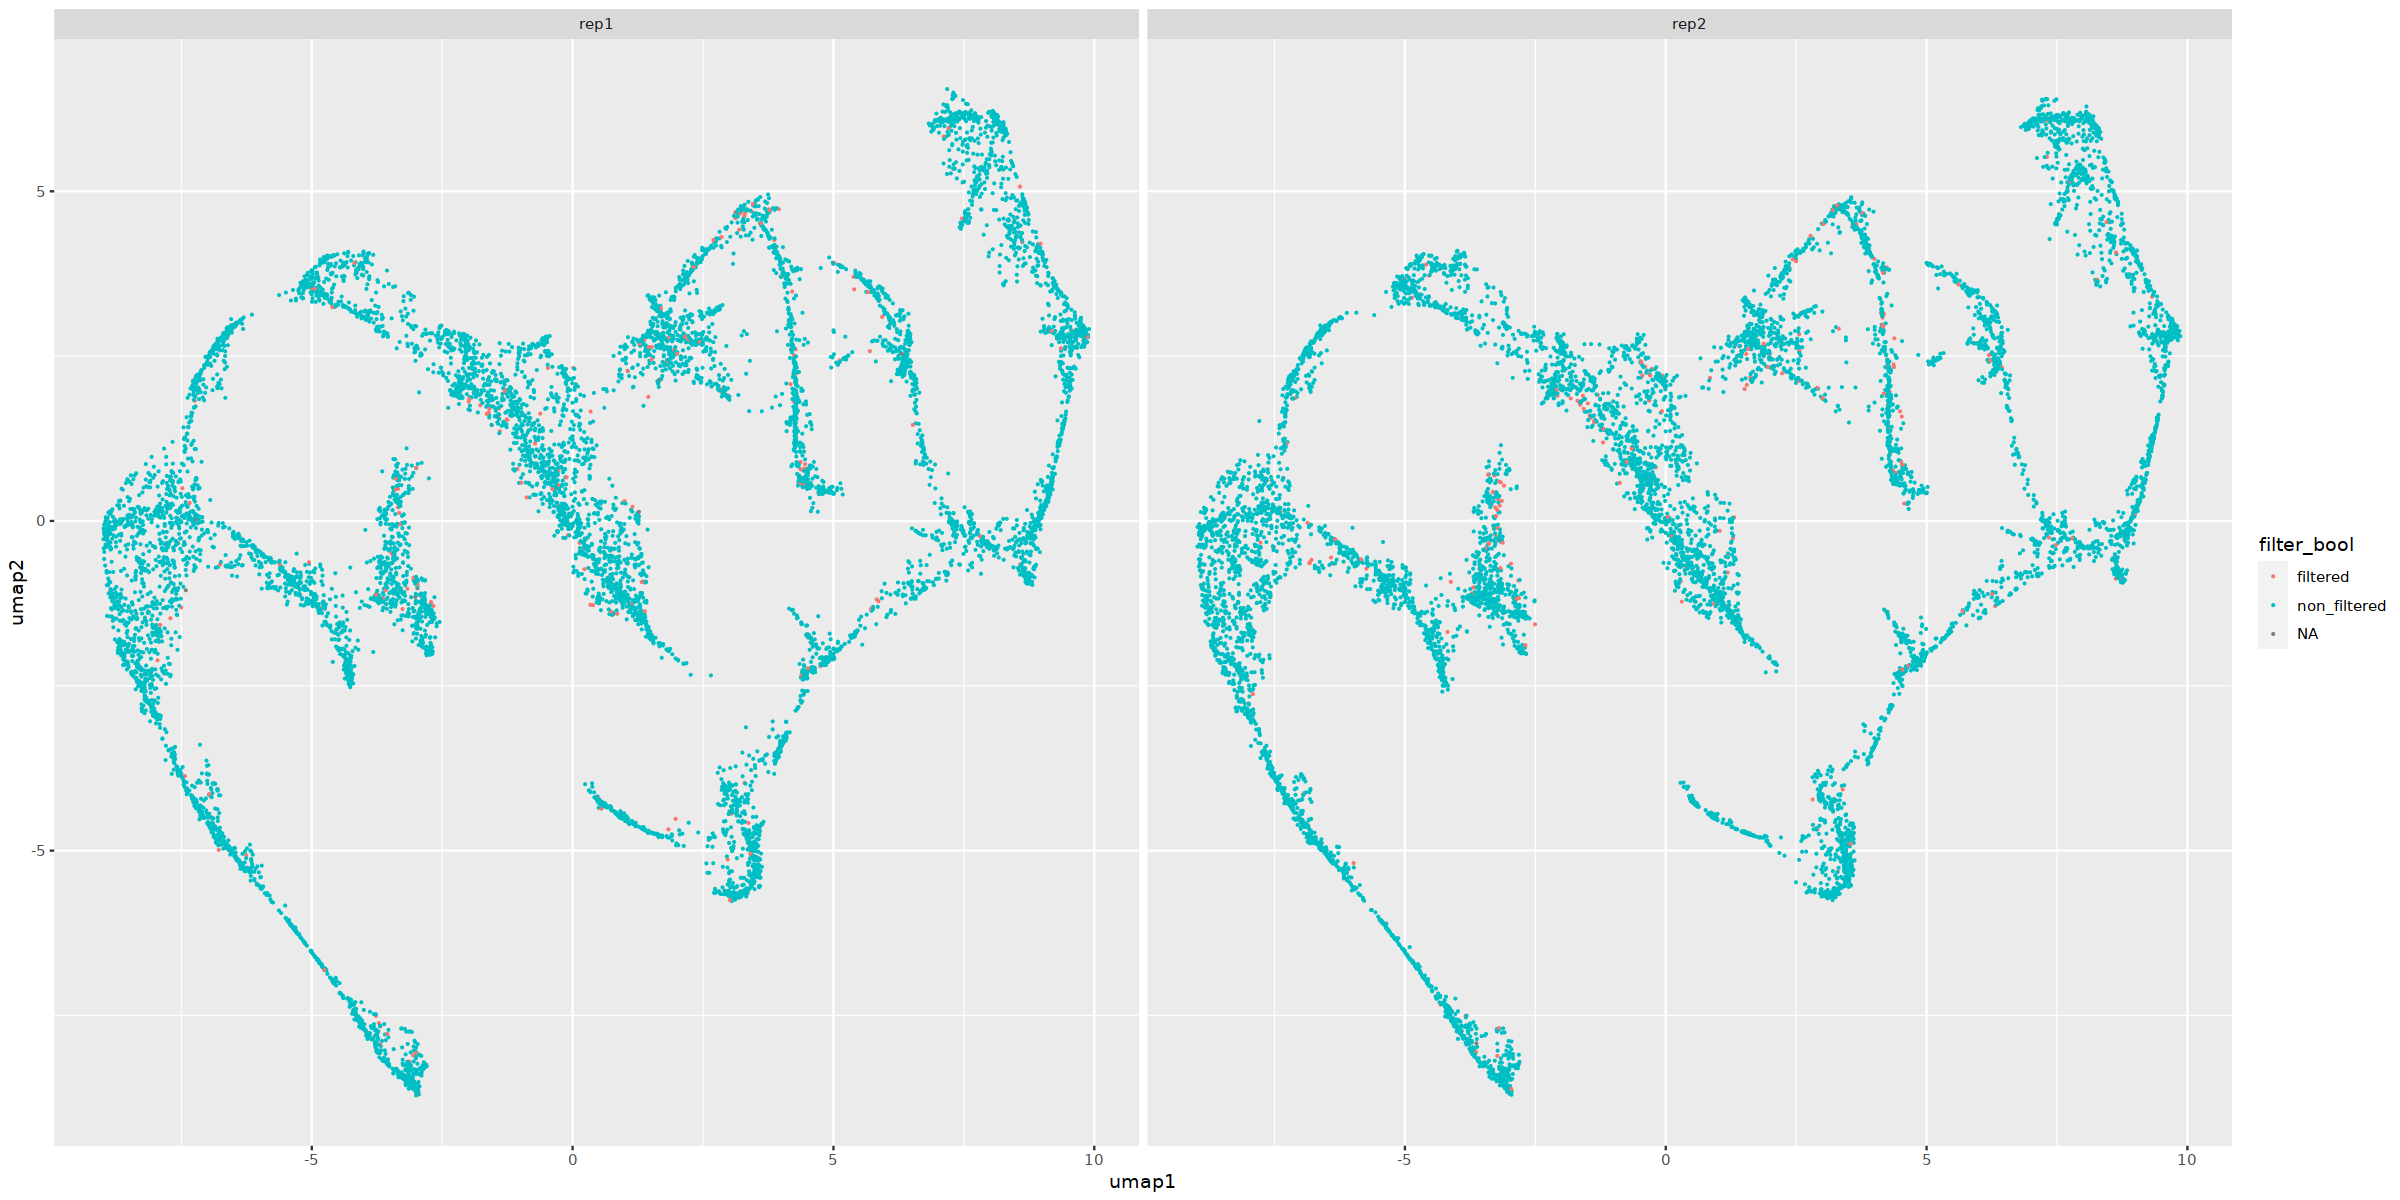

In [45]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

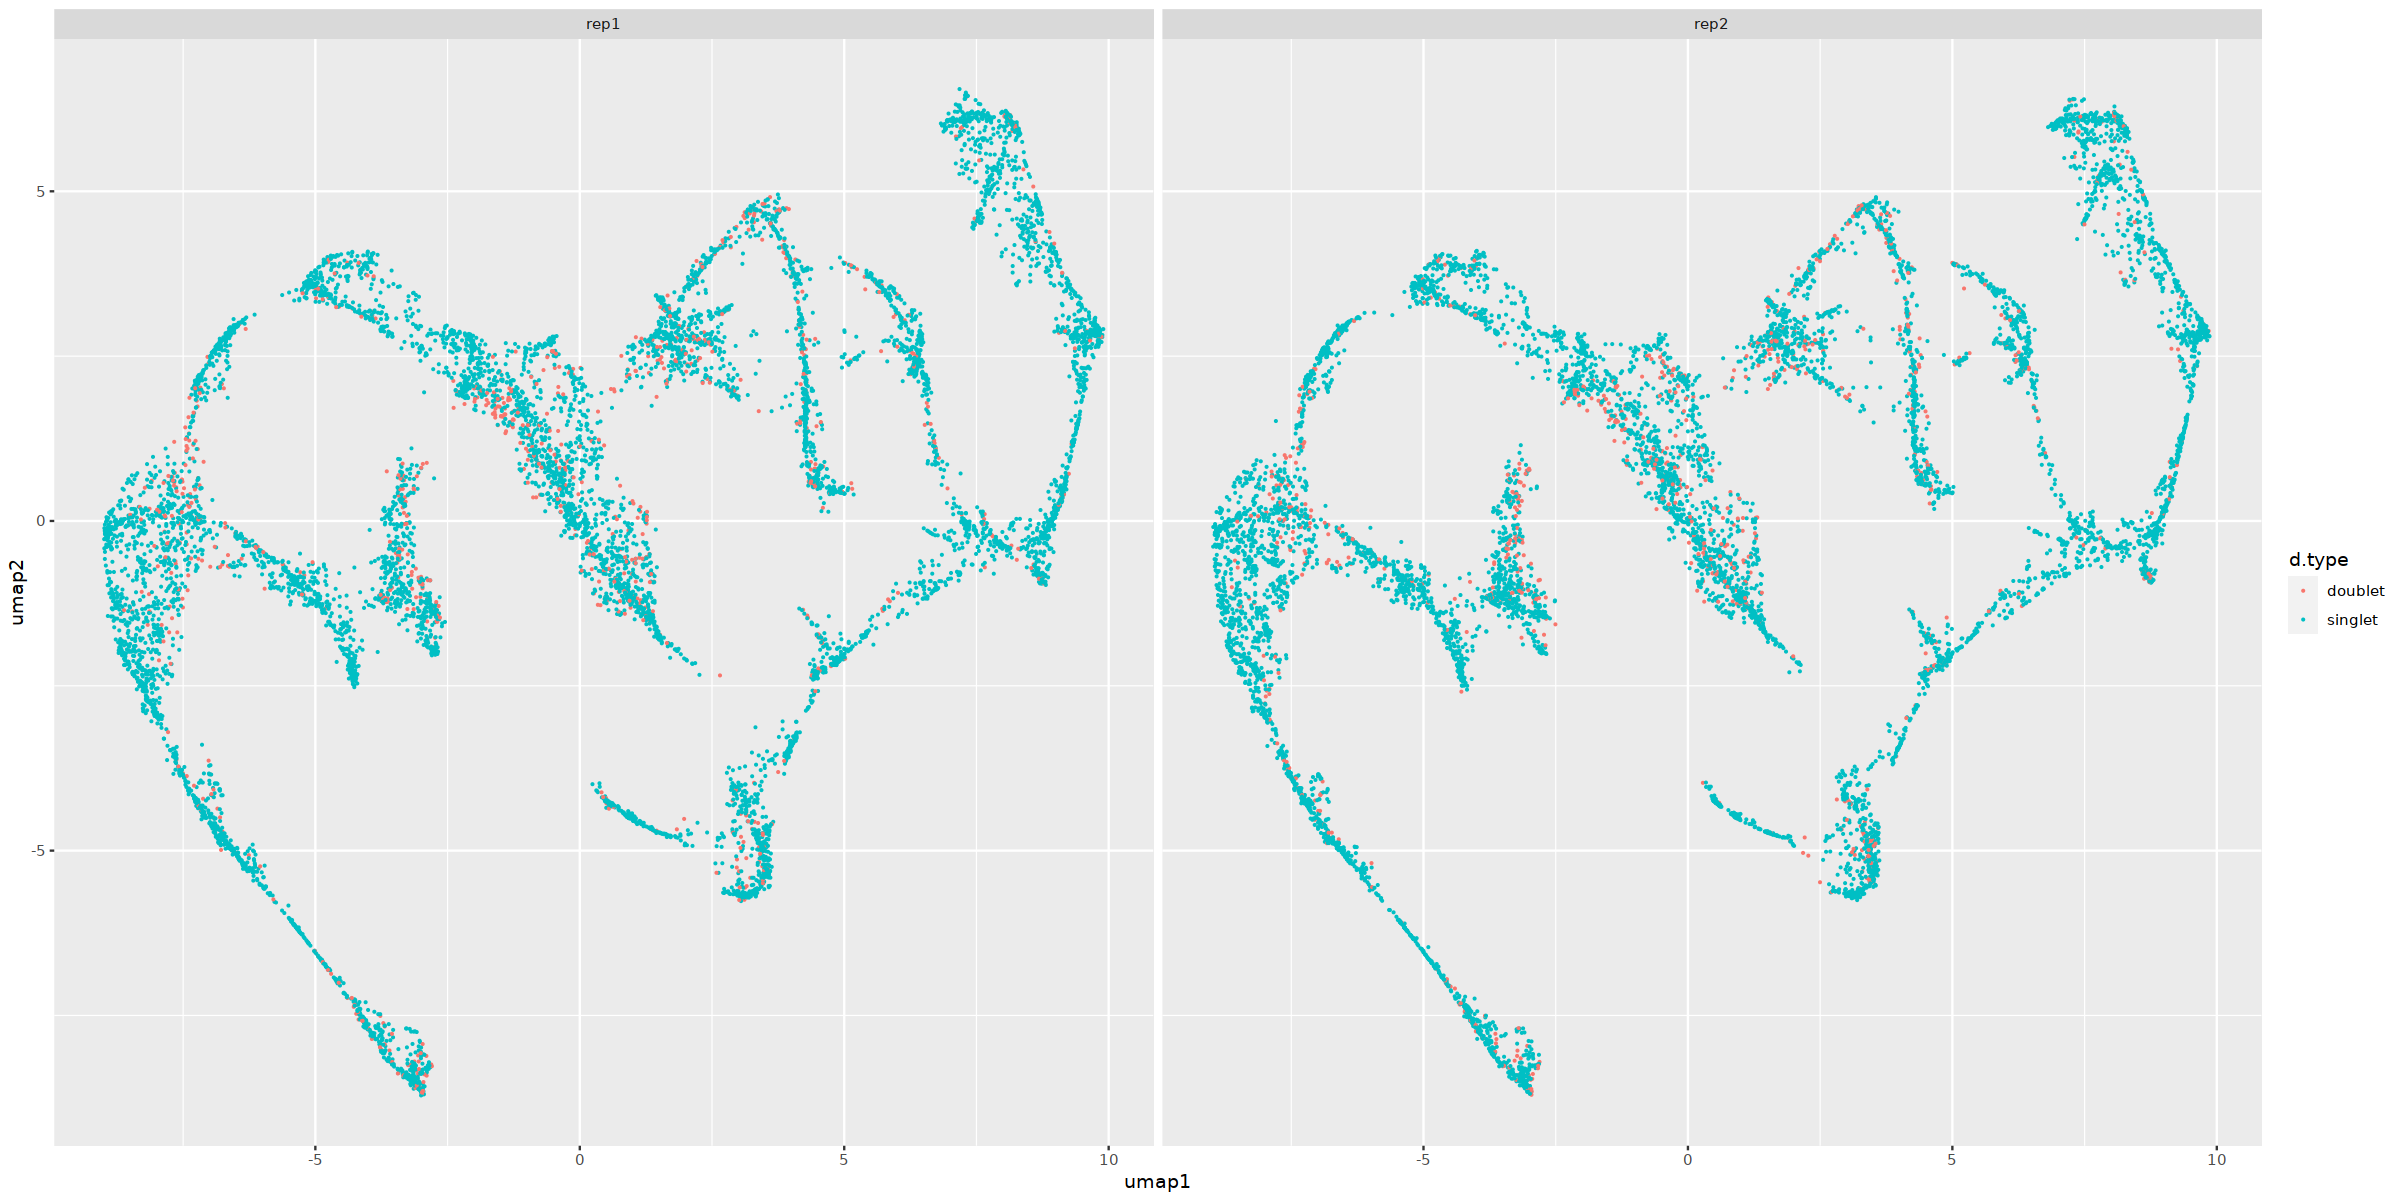

In [46]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = d.type)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [30]:
unique(tfidf.obj.dob.filt.removed.graph$data$filter_bool)

[1] "non_filtered" NA

In [49]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 1393  Filtered: cells = 16035 | peaks = 106707



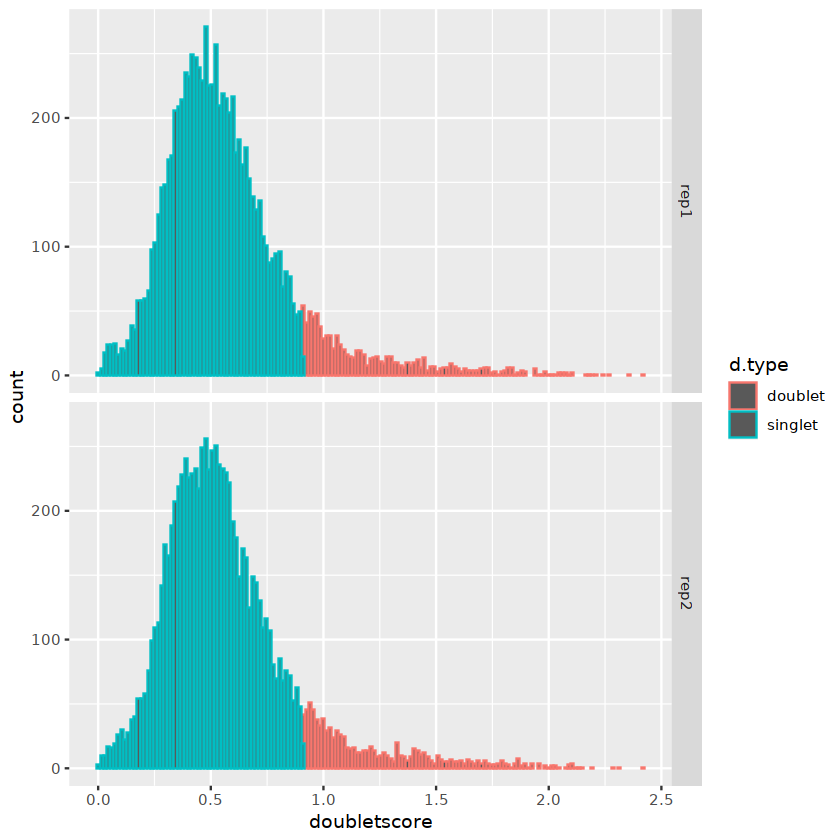

In [17]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    ggplot(., aes(doubletscore, color = d.type)) + geom_bar() + facet_grid(sampleID~.)

In [52]:
tfidf.obj.dob.filt.removed <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=T, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID

   * Doublet filtering * Input: cells = 17428 | peaks = 106707

   * Doublet filtering * Filtered (10.4%) : cells = 15607 | peaks = 106707



In [70]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2.0,
                        verbose=T,
                        svd_slotName= "NMF",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=25,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15374
Number of edges: 883982

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.8611
Number of communities: 30
Elapsed time: 16 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 15246

 - filtering clusters with low cell/read counts ...



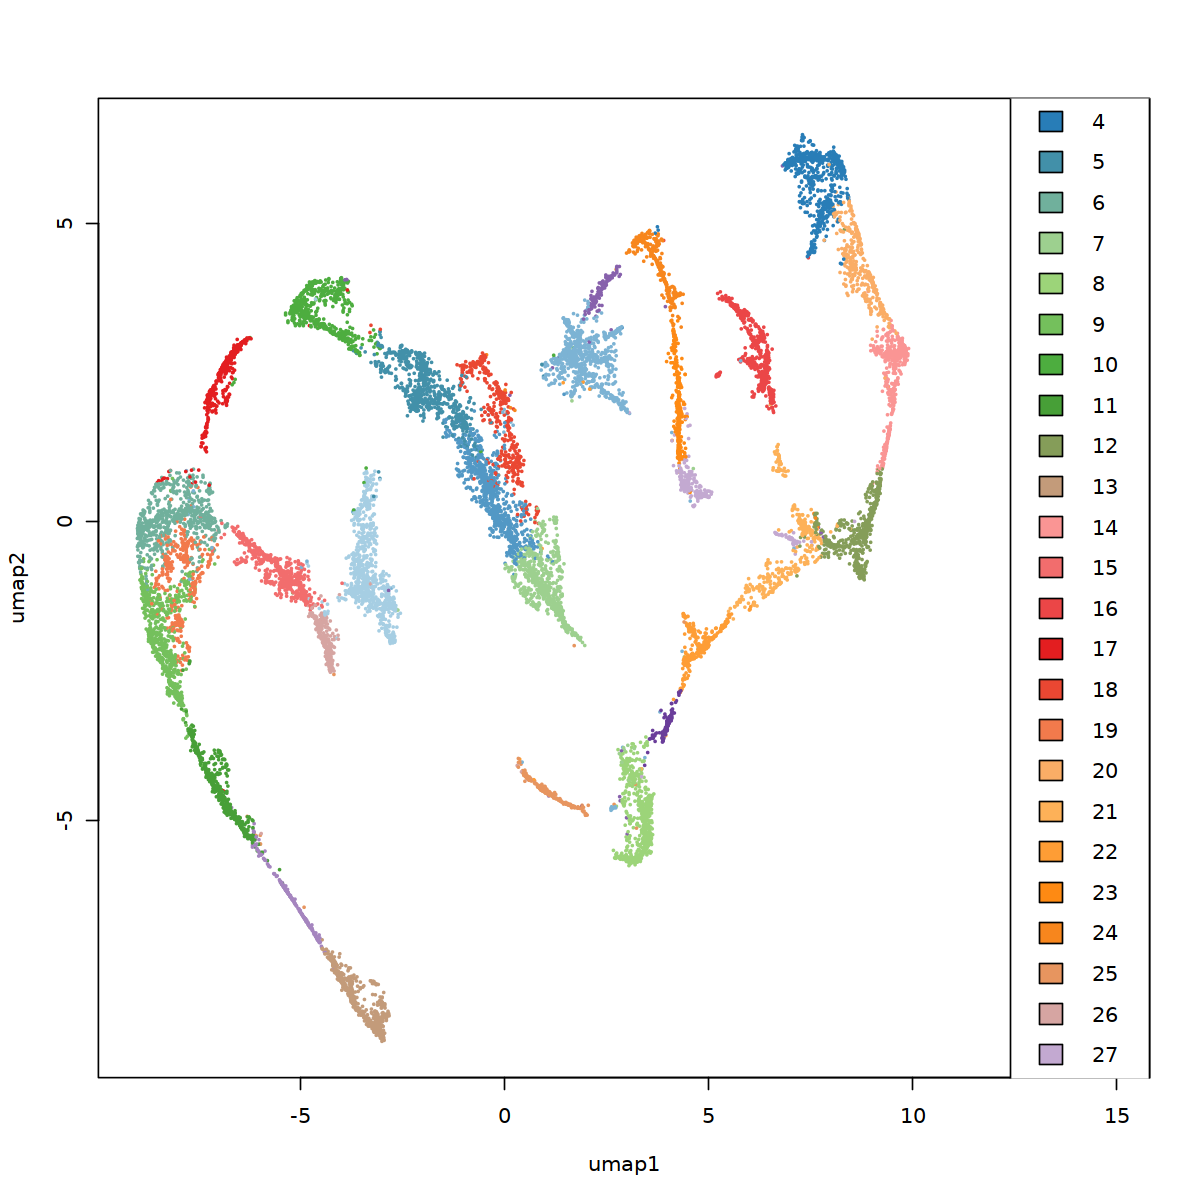

In [73]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()

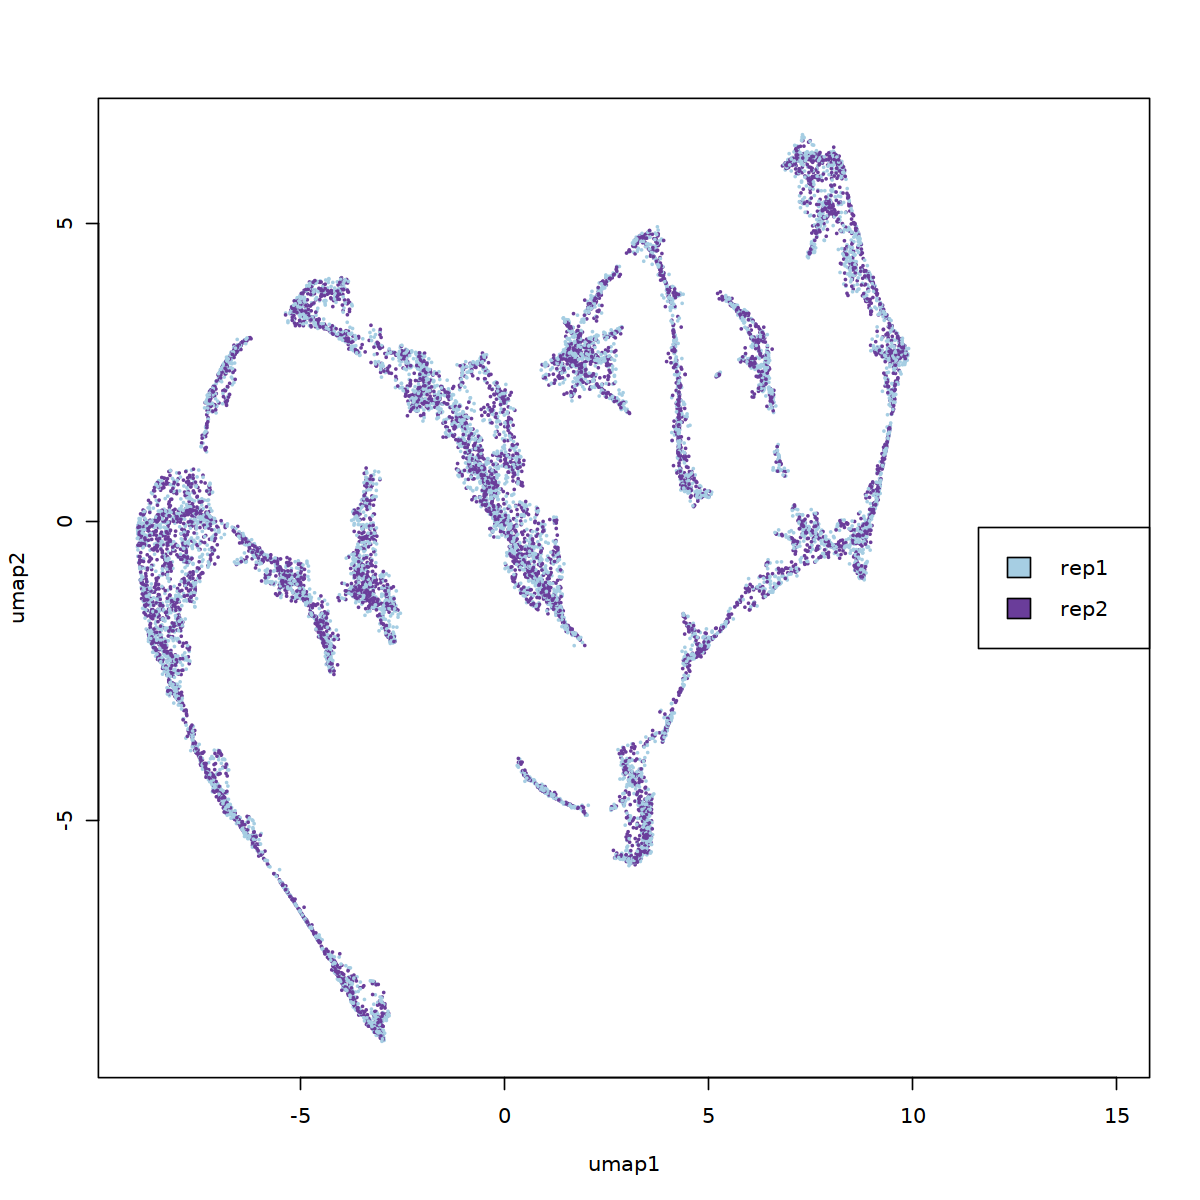

In [74]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

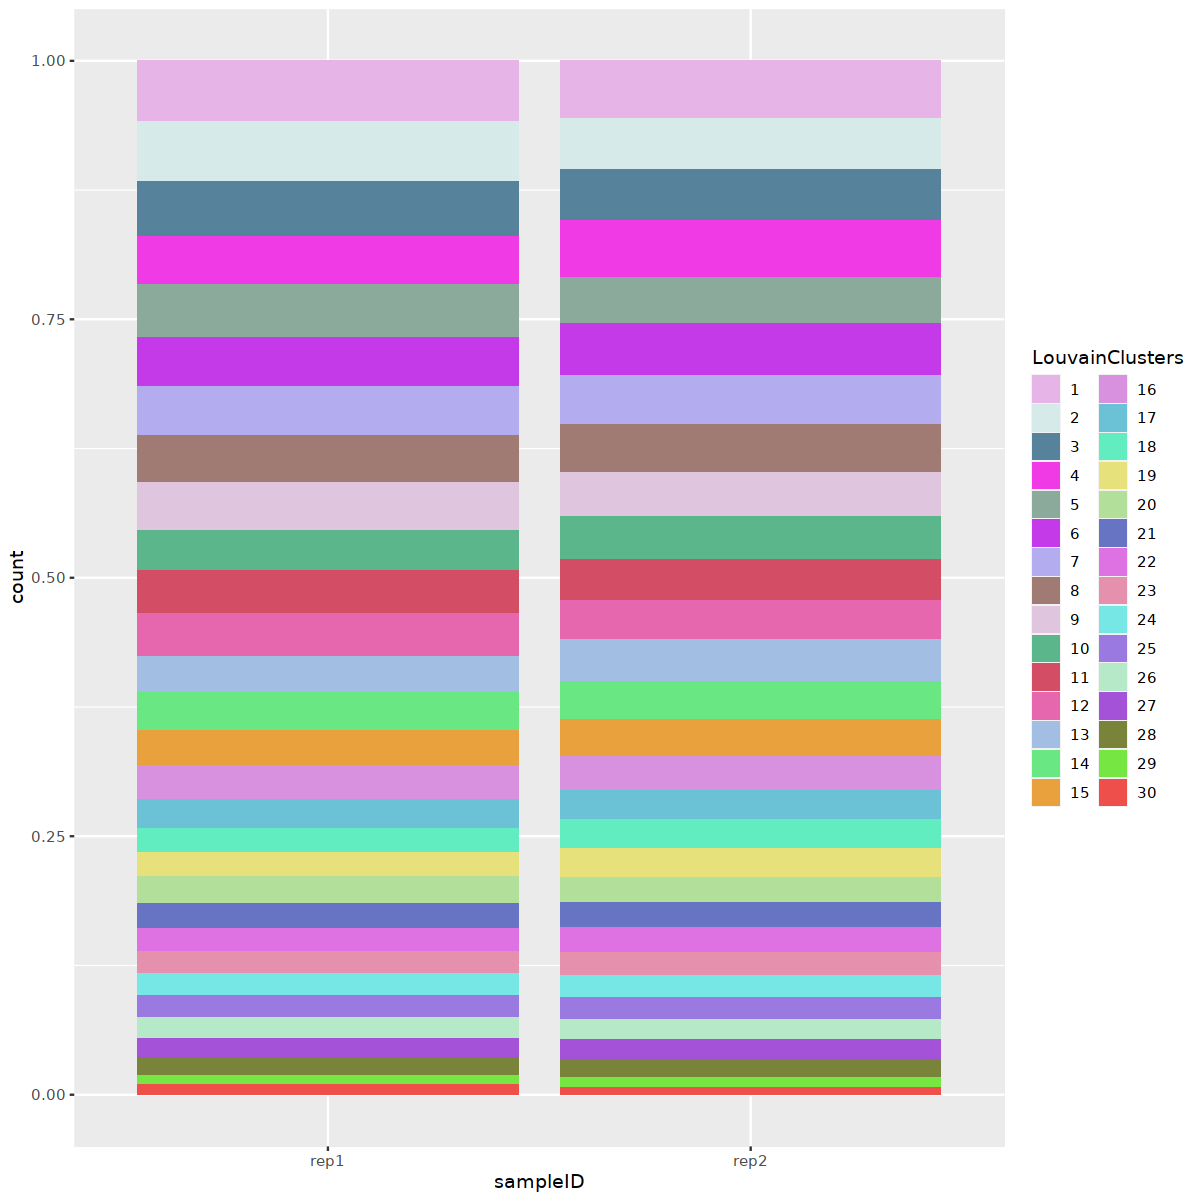

In [75]:
library(RColorBrewer)
other <- randomcoloR::distinctColorPalette(k = 41)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cell_converted_trible,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

In [61]:
str(tfidf.obj.dob.filt.clusters)

List of 13
 $ meta            :'data.frame':	15607 obs. of  12 variables:
  ..$ cellID      : chr [1:15607] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:GCCAATTAGCTTAGCGAGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1" ...
  ..$ total       : num [1:15607] 193716 159908 137820 133866 119905 ...
  ..$ tss         : num [1:15607] 115473 50092 80881 76902 69087 ...
  ..$ acrs        : num [1:15607] 154235 29336 99700 96929 90787 ...
  ..$ ptmt        : num [1:15607] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ nSites      : num [1:15607] 57999 80678 48802 47311 44916 ...
  ..$ log10nSites : num [1:15607] 4.76 4.91 4.69 4.67 4.65 ...
  ..$ sampleID    : chr [1:15607] "rep1" "rep1" "rep1" "rep1" ...
  ..$ umap1       : num [1:15607] 3.08 2.63 4.5 5.16 -3.24 ...
  ..$ umap2       : num [1:15607] -4.97 2.52 -2.39 -1.9 -8.25 ...
  ..$ doubletscore: num [1:15607] 0.224 0.418 0.5

In [76]:
#prefix <- "Sb_leaf.merged_replicates"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"
paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
nmf.meta <- tfidf.obj.dob.filt.clusters$Clusters
nmf.rd <- tfidf.obj.dob.filt.clusters$NMF

write.table(nmf.meta, file=paste0(output_location,prefix, ".NMF.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".NMF.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

[1] "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb_leaf.merged_replicates.merged_clusters.sparse"

In [77]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".NMF.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

### Run same Analysis but with SVD

In [6]:
devtools::document()

ERROR: Error: [ENOENT] Failed to realize 'Socrates': no such file or directory


In [1]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

rep_1 <- paste0(data_path,"Sb.Leaf_rep1_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"Sb.Leaf_rep2_QC_soc_obj.rds")
prefix <- "Sb_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

ℹ Loading Socrates

Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map,

[1] "Merging Object"


In [94]:
print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj

    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Socrates Obj"
[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"4 x values <= 0 omitted from logarithmic plot"
Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1 x value <= 0 omitted from logarithmic plot"


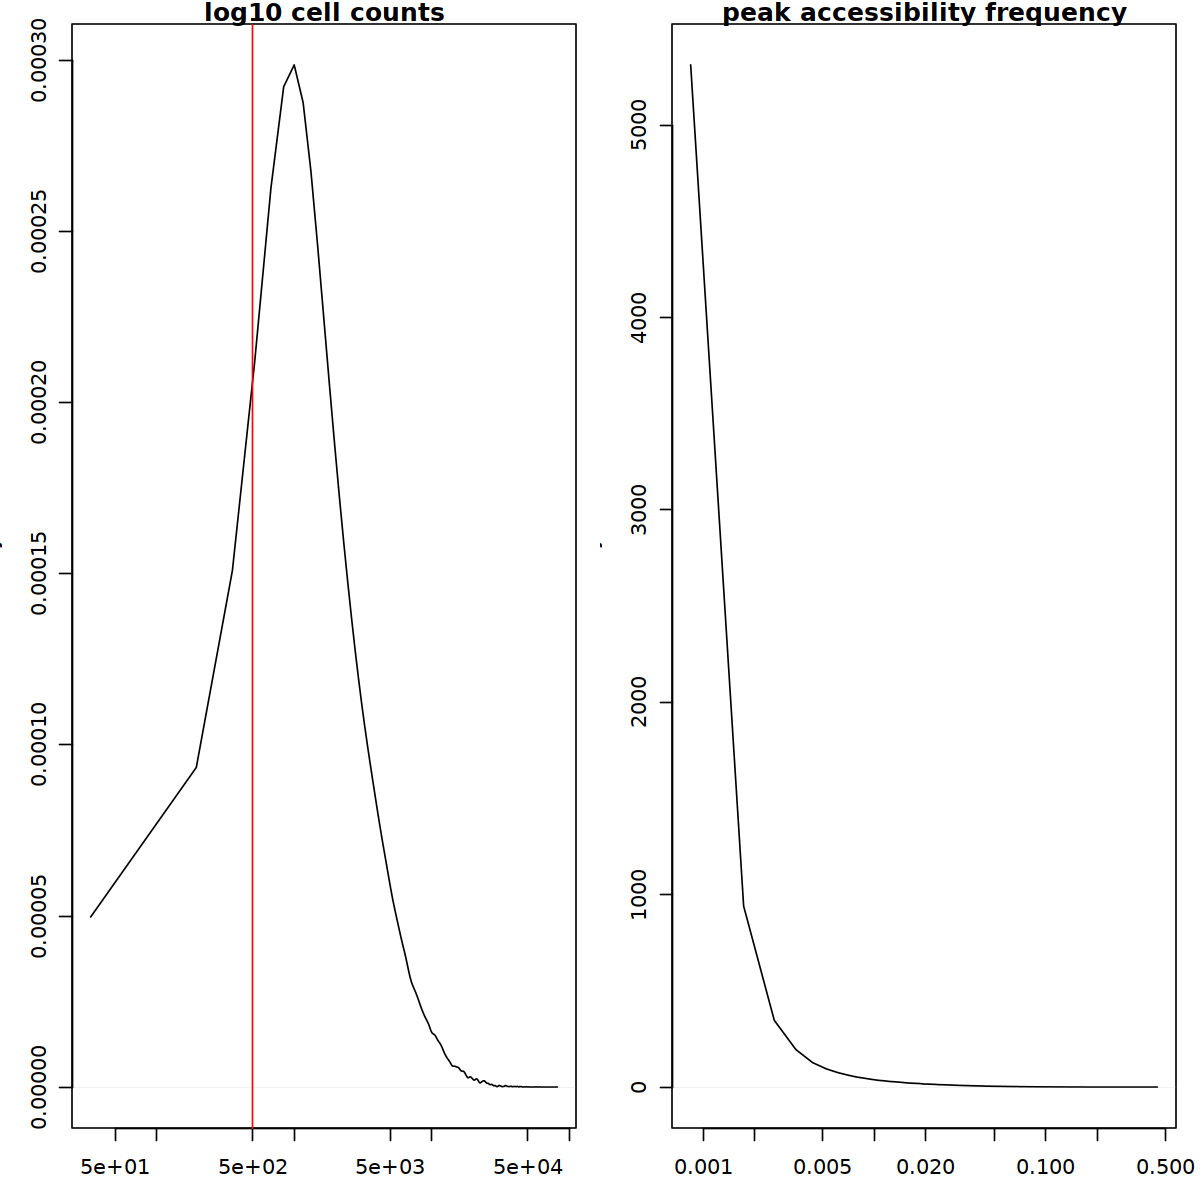

In [95]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [96]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)

In [97]:
# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=100,  # minimum number of accessible features per cell
                     min.t=0.001,  # minimum feature frequency across cells
                     max.t=0.001, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 17428 | peaks = 1295905

   * Filtered: cells = 17428 | peaks = 303469



In [91]:
str(soc.obj$counts)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:51224754] 1 2 5 6 7 8 9 10 12 13 ...
  ..@ p       : int [1:17426] 0 42420 58948 92943 125604 157913 177666 209104 237826 266361 ...
  ..@ Dim     : int [1:2] 73542 17425
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:73542] "Chr01_10010501_10011000" "Chr01_10011001_10011500" "Chr01_10011501_10012000" "Chr01_10013001_10013500" ...
  .. ..$ : chr [1:17425] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:GCCAATTAGCTTAGCGAGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1" ...
  ..@ x       : num [1:51224754] 1 1 1 1 1 1 1 1 1 1 ...
  ..@ factors : list()


In [ ]:
# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)


# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=100, 
                      num.var=0,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=500,
                       m.dist=0.1,
                        metric="manhattan",
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

16:18:54 UMAP embedding parameters a = 1.577 b = 0.8951

16:18:54 Read 17428 rows and found 99 numeric columns

16:18:54 Using Annoy for neighbor search, n_neighbors = 500

16:18:54 Building Annoy index with metric = manhattan, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:18:56 Writing NN index file to temp file /tmp/RtmpKr7wEE/file33e44eb4a69e

16:18:56 Searching Annoy index using 16 threads, search_k = 50000

16:19:02 Annoy recall = 100%

16:19:16 Commencing smooth kNN distance calibration using 16 threads

16:19:27 Initializing from normalized Laplacian + noise



In [ ]:
plotUMAP(soc.obj.project_umap, cex=0.3, column = "sampleID")

In [ ]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

In [ ]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

In [ ]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

In [ ]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    dplyr::mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore < remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

In [ ]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=T, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

In [ ]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt, 
                        res=4,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()




In [ ]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [ ]:
head(tfidf.obj.dob.filt.clusters)

In [ ]:
reload_bed_file <- function(obj, bed) {
    
    if(grepl(".gz$", bed)){
        obj$bed <- read.table(gzfile(as.character(bed)))
    }else{
        obj$bed <- read.table(as.character(bed))}
    
    return(obj)
}

In [ ]:
reload_gff_file <- function(obj, ann) {
    
    if(grepl(".gtf", ann)){
        anntype <- "gtf"
    }else{
        anntype <- "gff3"
    }
        
    gff <- suppressWarnings(suppressMessages(makeTxDbFromGFF(as.character(ann), format=anntype, dbxrefTag="Parent")))
    
    obj$gff <- gff
    return(obj)
}

In [ ]:
tfidf.obj.dob.filt.clusters <- reload_bed_file(tfidf.obj.dob.filt.clusters, "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed")

In [ ]:
tfidf.obj.dob.filt.clusters <- reload_gff_file(tfidf.obj.dob.filt.clusters, "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.primaryTrs.gff3")

In [ ]:
tfidf.obj.dob.filt.clusters$gff

In [ ]:
tfidf.obj.dob.filt.clusters.accessabiliy <- GeneBodyAccessibility(tfidf.obj.dob.filt.clusters)
                      
                      

In [ ]:
source("/home/jpm73279/Socrates/R/cluster_interrogation.R")

In [ ]:
library("presto")

In [ ]:
tfidf.obj.dob.filt.clusters.accessabiliy <- run_presto(tfidf.obj.dob.filt.clusters.accessabiliy,
          meta_slot = "Clusters",
          cluster_name = "LouvainClusters",
          counts_raw="sc_gene_ac")

In [ ]:
top_markers_per_cluster <- top_markers(tfidf.obj.dob.filt.clusters.accessabiliy$presto_marker,100)

In [ ]:

marker_list_sb_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/markers/Sb.leaf_markers_from_zm.markers.txt"
marker_list_sb <- read_delim(marker_list_sb_file, delim='\t', 
                                       col_names = TRUE)

In [ ]:


represented_marker_lst <- list()
for (i in unique(tfidf.obj.dob.filt.clusters.accessabiliy$Clusters$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(top_markers_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

In [ ]:
prefix <- "Sb_leaf.merged_replicates.updated_clustering_V4"

output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"
paste0(data_path, prefix,"SVD.merged_clusters.sparse")
# output text files
nmf.meta <- tfidf.obj.dob.filt.clusters$Clusters
nmf.rd <- tfidf.obj.dob.filt.clusters$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

In [ ]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

In [ ]:
saveRDS(tfidf.obj.dob.filt.clusters, file = paste0(output_location,prefix, ".SVD.full.rds"))

### Final Attempt at clustering with STRICT isolation of vairable CREs 

In [1]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

rep_1 <- paste0(data_path,"Sb.Leaf_rep1_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"Sb.Leaf_rep2_QC_soc_obj.rds")
prefix <- "Sb_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

ℹ Loading Socrates

Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map,

[1] "Merging Object"


[1] "Generating Socrates Obj"
[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"4 x values <= 0 omitted from logarithmic plot"
Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1 x value <= 0 omitted from logarithmic plot"


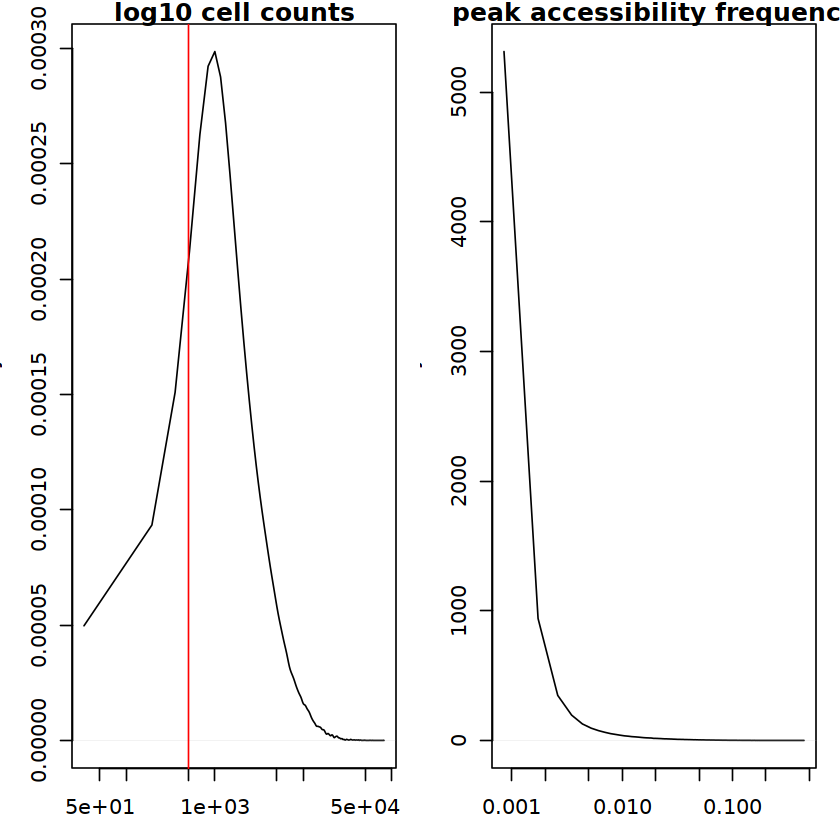

In [2]:
print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj

    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)


layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [3]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj.cleaned <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.008,  # minimum feature frequency across cells
                     max.t=0.2, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 17428 | peaks = 1295905

   * Filtered: cells = 17301 | peaks = 66765



In [4]:
set.seed(8)

# normalize with TFIDF ---------------------------------------------------
soc.obj.cleaned <- tfidf(soc.obj.cleaned)


# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj.cleaned,
                      method="SVD", 
                      n.pcs=30, 
                      num.var=40000,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=20,
                       m.dist=0.01,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

13:29:46 UMAP embedding parameters a = 1.896 b = 0.8006

13:29:46 Read 17301 rows and found 29 numeric columns

13:29:46 Using Annoy for neighbor search, n_neighbors = 20

13:29:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:29:49 Writing NN index file to temp file /tmp/Rtmp0qtcuE/file1266037a582c7

13:29:49 Searching Annoy index using 16 threads, search_k = 2000

13:29:49 Annoy recall = 100%

13:29:53 Commencing smooth kNN distance calibration using 16 threads

13:29:56 Initializing from normalized Laplacian + noise

13:29:56 Commencing optimization for 200 epochs, with 560248 positive edges

13:30:23 Optimization finished



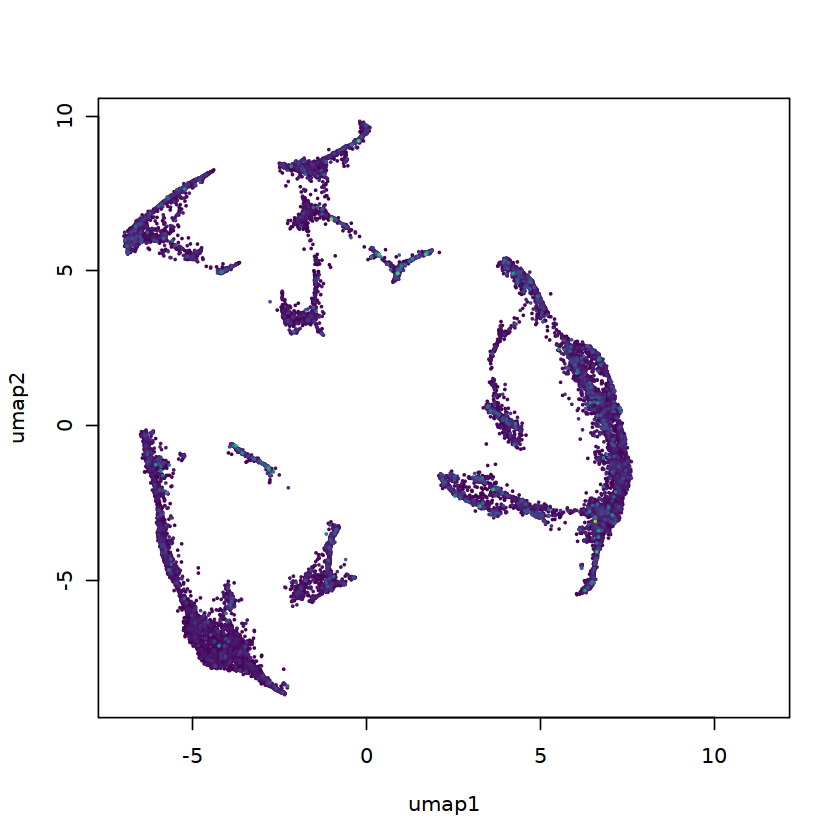

In [5]:
plotUMAP(soc.obj.project_umap, cex=0.3, column = "total")

In [6]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

 - Creating synthetic doublets ...

 - Created 85000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [7]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [10]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 566  Filtered: cells = 16735 | peaks = 66765



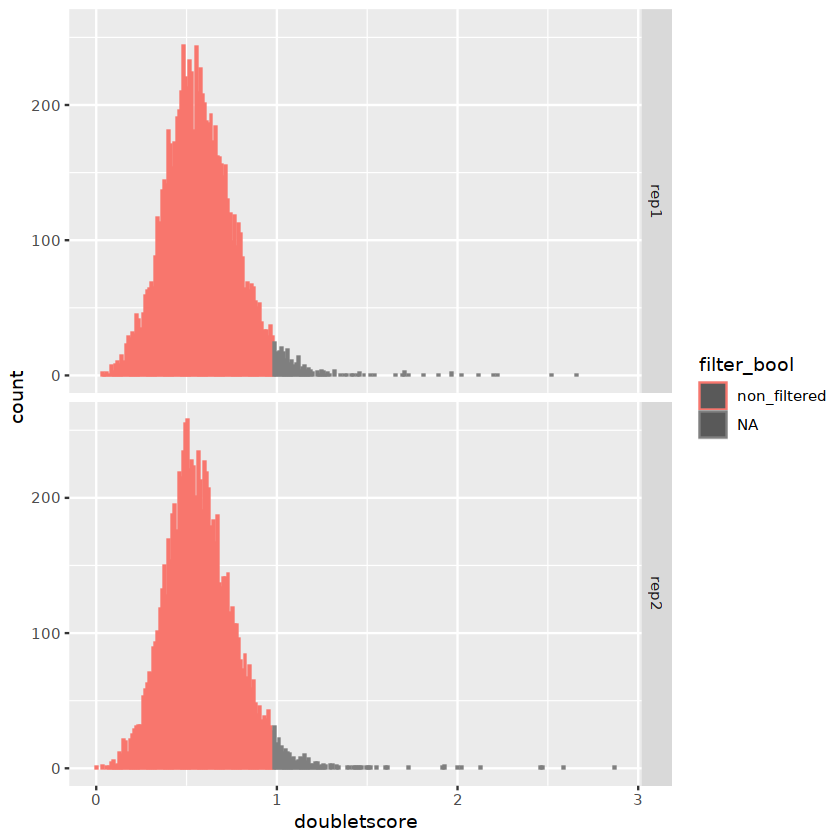

In [11]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    dplyr::mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore < remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

In [12]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=T, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID

   * Doublet filtering * Input: cells = 17301 | peaks = 66765

   * Doublet filtering * Filtered (10.4%) : cells = 15506 | peaks = 66765



 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15180
Number of edges: 1327412

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.8397
Number of communities: 34
Elapsed time: 41 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 14961

 - filtering clusters with low cell/read counts ...



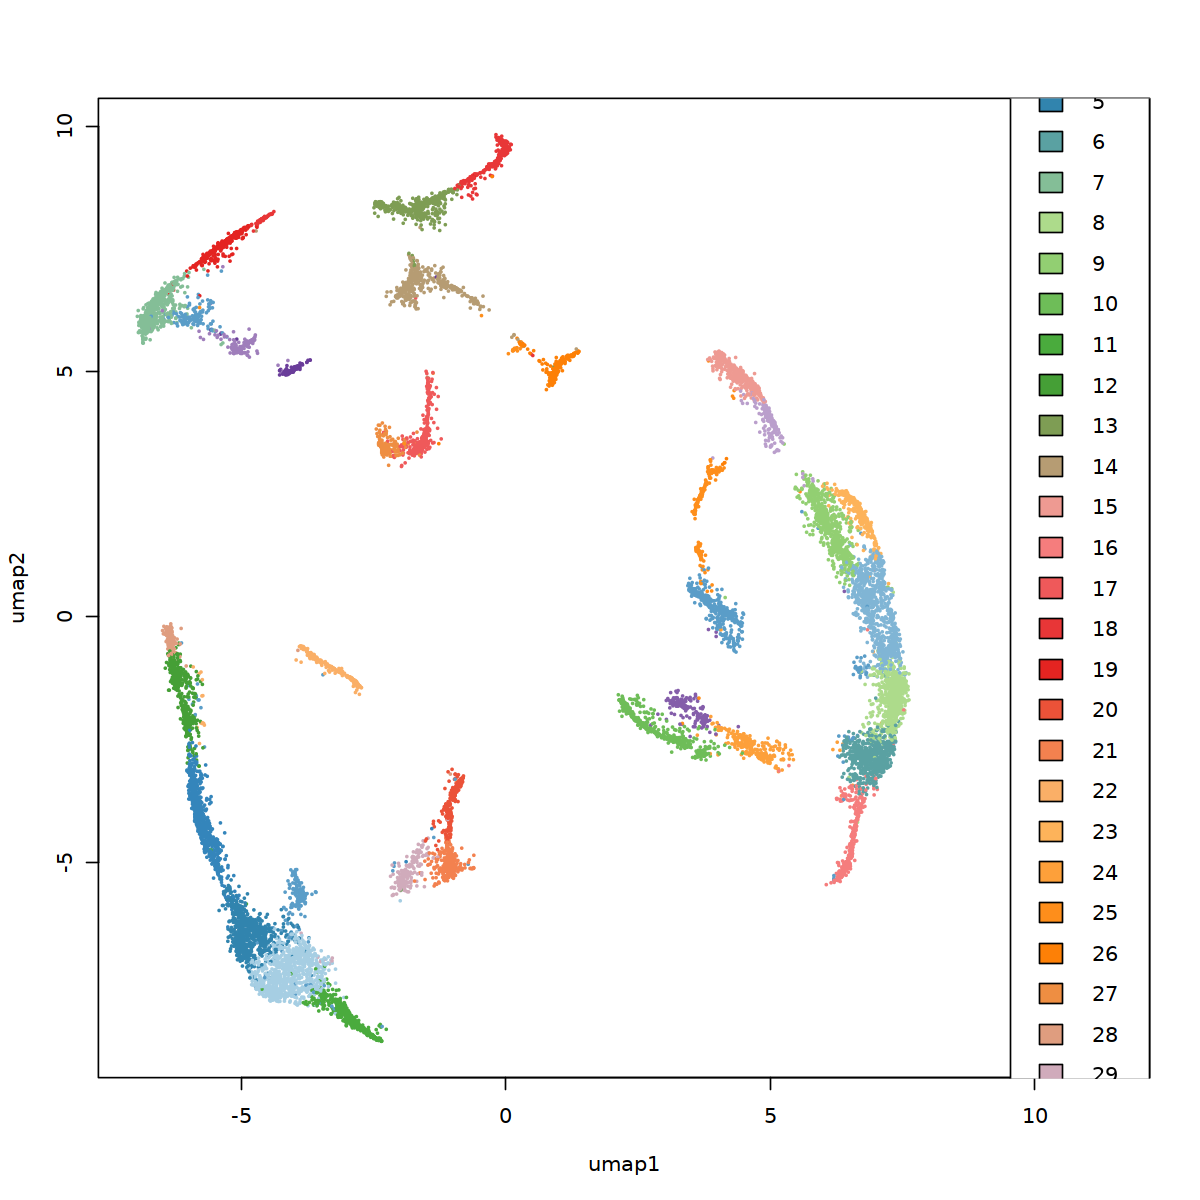

In [15]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt, 
                        res=2.5,
                        verbose=T,
                        svd_slotName= "SVD",
                                            m.clst = 100,
                        cleanCluster=T)

#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()




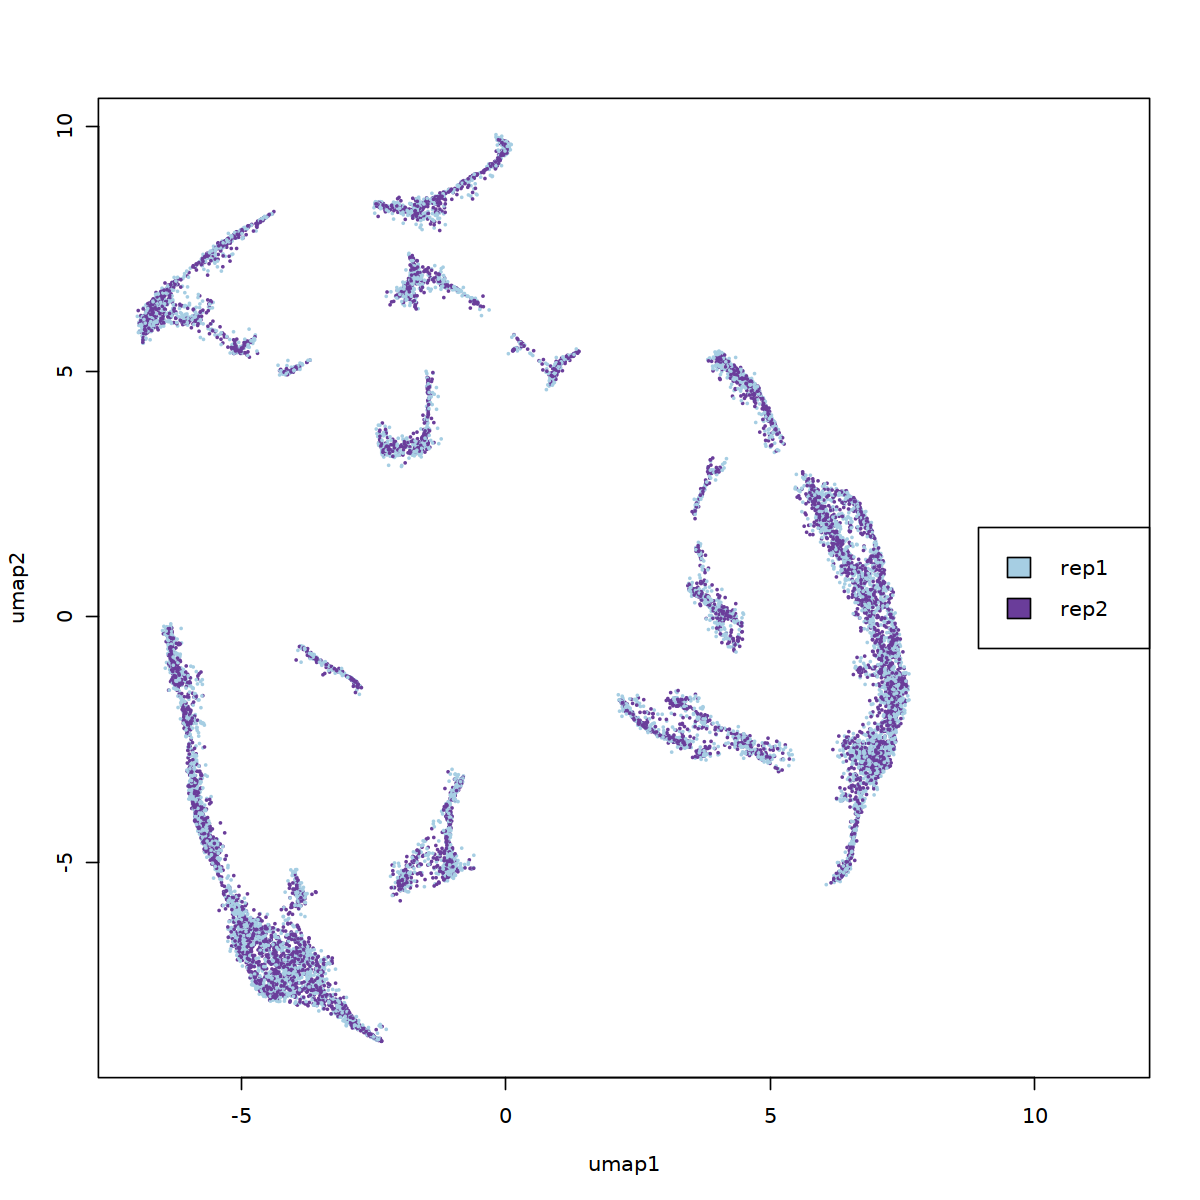

In [16]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [31]:
call_per_cluster_ACRs <- function(meta_obj, 
                                  slot_name, 
                                  cluster_name, 
                                  bed_integrations, 
                                  base_output_name="test_Rrun", 
                                  output_dir="test", 
                                  genome_file,
                                  verbose=FALSE){
    
    clust_name <- c(cluster_name)
    
    cell_converted_trible <- as_tibble(meta_obj[[slot_name]])
    
    
    generate_count_data <- cell_converted_trible  %>% 
        group_by(!!sym(clust_name))  %>% 
        summarise(counts_per_clust = n())
    
    print(generate_count_data)
    
    final_tribble <- left_join(cell_converted_trible, generate_count_data)  %>% 
        mutate(cluster_name_final = str_c(!!sym(clust_name), "_ncell_", counts_per_clust))

    
    write_delim(final_tribble, "test_output_name.2.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

    if(verbose){message("Calling peaks for Clusters - This may take some time. Check output terminal for info.")}
    generate_run_command = paste0("python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/call_scACRs.py -bed ", bed_integrations, 
                                  " -meta ", "test_output_name.2.txt", 
                                  " -col ", "cluster_name_final", 
                                  " -base ", base_output_name, 
                                  " -outdir ", output_dir, 
                                  " -bw yes -fai ", genome_file)
    
    print(generate_run_command)
    system(generate_run_command)

    
    if(verbose){message("Done!")}
    
    output_peak_file_name <- paste0(output_dir, "/", base_output_name, ".500bp_peaks.bed")
    
    meta_obj$acr_file_name <- output_peak_file_name
    return(meta_obj)
    
}

calculate_accessability <- function(meta_obj, 
                                    tn5_integration, 
                                    base_name="idk",
                                    bed_file_load = "acr_file_name",
                                    type = "acr",
                                    output_name="raw_accessability", 
                                    output_slot = "acr_counts_raw",
                                    output_dir = "."){
    
    peaks <- meta_obj[[bed_file_load]]
    final_output_name <- paste0(output_dir, "/", output_name)
    calculate_accessability <- paste0("python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/gene_body_acc.py -anno ", peaks, 
                                      " -tn5 ", tn5_integration," -type ", type, " -base ", base_name, " -p 10 -o ", final_output_name) 
    
    
    print(calculate_accessability)
    return_code <- system(calculate_accessability,intern = TRUE)
    
    meta_obj[output_slot] <- output_name
    
    return(meta_obj)
    
}

library(tidyverse)
library(devtools)
library(edgeR)
library('presto')
library(data.table)

library(tidyverse)
library('presto')
library(Matrix)

run_presto <- function(meta_obj, 
                       meta_slot, 
                       cluster_name, 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    clust_name <- c(cluster_name)

        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim=' ', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name) != TRUE))  %>% 
        arrange(!!sym(cluster_name))
    
    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))


    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))

    garbbed_louv_order <- as.vector(barcode_tibble[, cluster_name])
    print(dim(UIMatrix))
    print(dim(garbbed_louv_order))
    
    
    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj["presto_marker"] <- sparse_matrix_test
    
    return(meta_obj)
}



In [22]:
cleaned_cluster <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)  %>% 
    mutate(LouvainCluster_t = str_c("Louvain_c", LouvainClusters))

In [23]:
tfidf.obj.dob.filt.clusters$Clusters <- cleaned_cluster

In [24]:
setwd("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering")
bed_intersections <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed"
genome_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.chrom.size"

In [27]:
tfidf.obj.dob.filt.clusters <- call_per_cluster_ACRs(tfidf.obj.dob.filt.clusters, 
                                                     slot_name = "Clusters", 
                                                     cluster_name = "LouvainCluster_t",
                                                     bed_integrations = bed_intersections,
                                                     base_output_name = "Sb.V3_annot",
                                                     output_dir = "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.Louvain_cluster", 
                                                     genome_file= genome_file)

# A tibble: 33 × 2
   LouvainCluster_t counts_per_clust
   <chr>                       <int>
 1 Louvain_c1                   1038
 2 Louvain_c10                   530
 3 Louvain_c11                   523
 4 Louvain_c12                   504
 5 Louvain_c13                   473
 6 Louvain_c14                   450
 7 Louvain_c15                   424
 8 Louvain_c16                   417
 9 Louvain_c17                   407
10 Louvain_c18                   392
# … with 23 more rows


Joining, by = "LouvainCluster_t"


[1] "python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/call_scACRs.py -bed /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed -meta test_output_name.2.txt -col cluster_name_final -base Sb.V3_annot -outdir /scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.Louvain_cluster -bw yes -fai /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.chrom.size"


In [28]:
tfidf.obj.dob.filt.clusters$gene_bed_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.gene.bed"

In [ ]:
function(soc_obj)

In [29]:
tfidf.obj.dob.filt.clusters <- calculate_accessability(tfidf.obj.dob.filt.clusters,
                                                      tn5_integration= bed_intersections,
                                                       base_name = "Sb.LC_GeneAccessability",
                                                       bed_file_load = "gene_bed_file", 
                                                       type = "gene",
                                                       output_name="Sb.LC_GeneAccessability.txt", 
                                                       output_slot = "gene_acc_counts")

[1] "python /home/jpm73279/Mendieta_et_al_comparative_single_cell/python_scripts/scATAC/gene_body_acc.py -anno /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.gene.bed -tn5 /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed -type gene -base Sb.LC_GeneAccessability -p 10 -o ./Sb.LC_GeneAccessability.txt"


In [32]:
tfidf.obj.dob.filt.clusters.counts.final <- run_presto(tfidf.obj.dob.filt.clusters,
           meta_slot = "Clusters",
           counts_raw = "gene_acc_counts",
           cluster_name = "LouvainCluster_t")

ERROR: [1m[33mError[39m in [1m[1m`dplyr::select()`:[22m
[33m![39m Can't subset columns past the end.
[31m✖[39m Column `barcode` doesn't exist.


In [22]:
prefix <- "Sb_leaf.merged_replicates.knn_100.strict_filter"

output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"
paste0(data_path, prefix,"SVD.merged_clusters.sparse")
# output text files
nmf.meta <- tfidf.obj.dob.filt.clusters$Clusters
nmf.rd <- tfidf.obj.dob.filt.clusters$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


[1] "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb_leaf.merged_replicates.knn_100.strict_filterSVD.merged_clusters.sparse"

In [23]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

In [24]:
saveRDS(tfidf.obj.dob.filt.clusters, file = paste0(output_location,prefix, ".SVD.full.rds"))